# Introduction


---


#### This Notebook is written for Shoreline Identification using Optical Sensors.  The proposed methodology utilize Landsat images with deterministic approach to estimate and define shorelines with sub-pixel accuracy. A sample application is presented to Monitoring Northern Shore of Egypt.

#### When utilizing the code provided within this notebook, it is kindly requested that proper attribution be given by citing the accompanying article. Ensuring appropriate acknowledgment of the referenced article serves to acknowledge the original source and supports the principles of intellectual integrity and scholarly recognition.


---


"Tamer ElGharbawi, Mosbeh R.Kaloop, Jong Wan Hu, and Fawzi Zarzoura. "Subpixel Accuracy of Shoreline Monitoring using Developed Landsat Series and Google Earth Engine Technique." PFG–Journal of Photogrammetry, Remote Sensing and Geoinformation Science (2023) Shoreline_Monitoring_using_Developed_Landsat_Series_with_Subpixel_Accuracy.ipynb"


---



#Authenticate GEE account and Connect to GoogleDrive

In [80]:
# Import GEE and Authenticate Account
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

from google.colab import drive
drive.mount('/content/drive')

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=XXLc3K1-OdT7ApHFn724lmDUXacc4aQlV4CsINkkf_Q&tc=4ULq6a6zYJUEmpDOEiZoRyZFfGHDBJoG_BoLmT22LWw&cc=XTJr1GvpGPToRjJq82_h1BxhINlJAtm5_zP7R3u7zEY

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1Adeu5BVpRmUECXqi_hvsrAp64dsiJhNDgSBuajODdM-8G44pcq5Rk2UeAZc

Successfully saved authorization token.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install and import Liberaries

In [91]:
# Installs geemap package
import subprocess

try:
    import geemap
except ImportError:
    print('geemap package not installed. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

In [92]:
# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal
# Install rtree - Geopandas requirment
!apt install python3-rtree
# Install Geopandas
!pip install geopandas
# Install descartes - Geopandas requirment
!pip install descartes
# Install plotlyExpress
!pip install plotly_express

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package python-gdal is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source
However the following packages replace it:
  gdal-bin

E: Package 'python-gdal' has no installation candidate
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-rtree is already the newest version (0.9.7-1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [93]:
# Import Python Codes and Modules used in this Notebook
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, gamma, f, chi2
import IPython.display as disp
import time
from datetime import datetime, timedelta
import branca.colormap as cm
import pprint
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import os
import geemap
import pandas as pd
import folium
import seaborn as sns
import geemap.chart as chart
import warnings
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
import matplotlib
import math
Map = geemap.Map()
%matplotlib inline


In [94]:
from google.colab import output
output.enable_custom_widget_manager()

# Define Landsat Related Functions

In [95]:
# Read, Filter, Scale and Clip Data [Remove Clouds and Clouds Shadow]

# Define bits to extract from Landsat Image
def getQABits(image, start, end, newName):
  # Compute the bits we need to extract.
  pattern = 0
  for i in (start, end+1, 1):
    pattern += math.pow(2, i)

  return image.select([0], [newName]).bitwiseAnd(pattern).rightShift(start)

# A function to mask out cloud Shadows pixels.
def cloud_shadows(image):
  QLabel=['QA_PIXEL']
  BIT=4
  # Select the QA band.
  QA = image.select(QLabel)
  # Get the internal_cloud_algorithm_flag bit.
  return getQABits(QA, BIT,BIT, 'Cloud_shadows').eq(0)

# A function to mask out cloudy pixels.
def clouds(image):
  QLabel=['QA_PIXEL']
  BIT=3
  # Select the QA band.
  QA = image.select(QLabel)
  # Get the internal_cloud_algorithm_flag bit.
  return getQABits(QA, BIT,BIT, 'Cloud').eq(0)

# Main function to maskout Clouds and Cloud Shadows
def maskClouds(image):
  cs = cloud_shadows(image)
  c = clouds(image)
  image = image.updateMask(cs)
  return image.updateMask(c)

# Applies scaling factors for Image.
def applyScaleFactors(IMG):
  opticalBands = IMG.select('SR_B.*').multiply(0.0000275).add(-0.2)
  thermalBands = IMG.select('ST_B.*').multiply(0.00341802).add(149.0)
  IMG_NEW=ee.Image(opticalBands)
  IMG_NEW=ee.Image(IMG_NEW.addBands(thermalBands))
  return IMG_NEW

# Applies Date and Location filter.
def LS8_Filter(IMG,START_DATE,END_DATE,AOI):
  IMG_coll = (IMG.filterDate(START_DATE, END_DATE)
  .filterBounds(AOI))
  return IMG_coll



# Statstical Distributions Analysis

In [96]:
# Statsitcal Distributions to Select Pattern From

distn_names = ['norm',
 'alpha',
 'beta',
 'cauchy',
 'chi',
 'chi2',
 'expon',
 'exponnorm',
 'f',
 'genlogistic',
 'genexpon',
 'genextreme',
 'gamma',
 'gengamma',
 'halfcauchy',
 'halflogistic',
 'halfnorm',
 'johnsonsb',
 'johnsonsu',
 'loggamma',
 'lognorm',
 'maxwell',
 'ncf',
 't',
 'nct',
 'powerlaw',
 'powerlognorm',
 'powernorm',
 'rdist',
 'rayleigh',
 'rice',
 'recipinvgauss',
 'semicircular',
 'skewnorm',
 'truncexpon',
 'truncnorm',
 'uniform',
 'gennorm',
 'halfgennorm']

In [97]:
# Functions modified After:
# https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python

# This cell to iterate Water and Land Bands and estimate PDF
# Define MatPlot figure style
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
# Function to fit data to Disributions
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    # y probabilities, x bin edges
    y, x = np.histogram(data, bins=bins, density=True)
    # make x the bin centers
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data

    for ii, distribution in enumerate(distn_names):

        #print("{:>3} / {:<3}: {}".format(ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))

        except Exception:
            pass


    return sorted(best_distributions, key=lambda x:x[2])

# This cell to iterate Water and Land Bands and estimate PDF
def FindBestFitIterate(gdf):
  my_lis=gdf.columns

  best_dist_Bands = []

  for index,item in enumerate(my_lis):

    print ('Band =',item )
    data=gdf.iloc[:,index]

    # Find best fit distribution
    best_distibutions = best_fit_distribution(data, 100)
    best_dist = best_distibutions[0]
    best_dist_Bands.append((index, item, best_dist))

  return best_dist_Bands

def make_pdf(dist, params, size):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get same start and end points of distribution
    start = dist.ppf(0.001, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.001, loc=loc, scale=scale)
    end = dist.ppf(0.999, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.999, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf, x, y

# Find PDF and get random data

def FindBestFitPDF(gdf,best_dist_Bands,size):
  my_lis=gdf.iloc[0,:]

  pdf_bands = []
  X_bands = []
  Y_bands = []

  for index,item in enumerate(my_lis):

    # Find best fit distribution

    best_dist = best_dist_Bands[index][2]

    [pdf, X_pdf, Y_pdf] = make_pdf(best_dist[0], best_dist[1],size)

    pdf_bands.append(pdf)
    X_bands.append(X_pdf)
    Y_bands.append(Y_pdf)

  return pdf_bands, X_bands, Y_bands

In [98]:
# Functions to Estimate Water Percentage

def Water_Perc_Cal_LS8(X_Val,IMG):
  WATER_PER=((IMG.select('SR_B1').multiply(X_Val[0])).add(IMG.select('SR_B2').multiply(X_Val[1]))
    .add(IMG.select('SR_B3').multiply(X_Val[2])).add(IMG.select('SR_B4').multiply(X_Val[3]))
    .add(IMG.select('SR_B5').multiply(X_Val[4])).add(IMG.select('SR_B6').multiply(X_Val[5]))
    .add(IMG.select('SR_B7').multiply(X_Val[6])).add(IMG.select('ST_B10').multiply(X_Val[7])).add(X_Val[8]))
  return WATER_PER

def Water_Perc_Cal_LS7(X_Val,IMG):
  WATER_PER=((IMG.select('SR_B1').multiply(X_Val[0])).add(IMG.select('SR_B2').multiply(X_Val[1]))
    .add(IMG.select('SR_B3').multiply(X_Val[2])).add(IMG.select('SR_B4').multiply(X_Val[3]))
    .add(IMG.select('SR_B5').multiply(X_Val[4])).add(IMG.select('SR_B7').multiply(X_Val[5]))
    .add(IMG.select('ST_B6').multiply(X_Val[6])).add(X_Val[7]))
  return WATER_PER

# Define Region of Interest As a GeoJason

In [99]:
# Region of Intrest ShoreLine in Northen Egypt, and the Buffer Distance

# Buffer Distance in Meters
Buffer = 500.0

# Region of Interest in GeoJason
ShoreLine_ROI = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              31.415109201571426,
              31.507316461207623
            ],
            [
              31.405443438874357,
              31.492207157385934
            ],
            [
              31.515995599722856,
              31.445833832814287
            ],
            [
              31.526064102532075,
              31.46043531991998
            ],
            [
              31.415109201571426,
              31.507316461207623
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

In [100]:
# Read and Define Region of Interst

#call function
ShoreLine_SHP = geemap.geojson_to_ee(ShoreLine_ROI)

# Create Buffer ROI
def SHP_Buffer(SHP):
  return SHP.buffer(Buffer)

ShoreLine_SHP = ShoreLine_SHP.map(SHP_Buffer)

aoi = ShoreLine_SHP.geometry()

# This Section makes the Analysis for a single time epoch.

In [123]:
# Define Time Frame

Start_Monitor_Date = '2022-06-01'
End_Monitor_Date = '2022-08-31'

YY = int(Start_Monitor_Date[:4])
print(Start_Monitor_Date)
print(End_Monitor_Date)

2022-06-01
2022-08-31


In [124]:
# Start Analysis
from google.colab import files

# Create Empty image with zero value
WATER_PER_Monitor=ee.Image(0).select([0], ['Filler'])

if (YY>=2013):
  LS=8
elif (YY < 2012):
  LS=5
else:
  LS=7

# Time Frame
START_DATE = ee.Date(Start_Monitor_Date)
END_DATE = ee.Date(End_Monitor_Date)

# Read LANDSAT Data
if (LS==8):
  # Read Landsat 8
  LS_Data = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
  cols = ['SR_B1',	'SR_B2',	'SR_B3',	'SR_B4',	'SR_B5','SR_B6',	'SR_B7', 'ST_B10']
elif (LS==7):
  # Read Landsat 7
  LS_Data = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2")
  cols = ['SR_B1',	'SR_B2',	'SR_B3',	'SR_B4',	'SR_B5',	'SR_B7', 'ST_B6']
else:
  # Read Landsat 5
  LS_Data = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")
  cols = ['SR_B1',	'SR_B2',	'SR_B3',	'SR_B4',	'SR_B5',	'SR_B7', 'ST_B6']

# Mask Clouds and Clouds Shadow
LS_Data = LS_Data.map(maskClouds)
# Filter Dates, Area of Interset and Apply shift and scale
LS_Data = LS8_Filter(LS_Data,START_DATE,END_DATE,aoi).map(applyScaleFactors)
# Calculate Median and Clip
LS_Data_median=ee.Image(LS_Data.median().clip(aoi))

# Calculate NDVI and MNDWI
if (LS==8):
  MNDWI= LS_Data_median.normalizedDifference(['SR_B3', 'SR_B6'])
  NDVI= LS_Data_median.normalizedDifference(['SR_B5', 'SR_B4'])
else:
  MNDWI= LS_Data_median.normalizedDifference(['SR_B2', 'SR_B5'])
  NDVI= LS_Data_median.normalizedDifference(['SR_B4', 'SR_B3'])


MaskForLand=LS_Data_median.updateMask(NDVI.lte(0.15).gte(0.05)).updateMask(MNDWI.lte(-0.2))
MaskForWater=LS_Data_median.updateMask(NDVI.lte(-0.2)).updateMask(MNDWI.gte(0.2))

# Select Training Points from Image
# Make the training dataset.
DataSet_Land1 = MaskForLand.sample(**{
    'region': aoi,
    'scale': 30,
    'seed': 42,
    'numPixels': 1000000,
    'dropNulls': True,
    'geometries': True  # Set this to False to ignore geometries
})

DataSet_Water1 = MaskForWater.sample(**{
    'region': aoi,
    'scale': 30,
    'seed': 42,
    'numPixels': 1000000,
    'geometries': True  # Set this to False to ignore geometries
})

if (LS==8):
  # Filter Landsat 8
  DataSet_Land1 = DataSet_Land1.filter(ee.Filter.lte('SR_B1', 1.2)).filter(ee.Filter.lte('SR_B2', 1.2)).filter(ee.Filter.lte('SR_B3', 1.2)) \
                .filter(ee.Filter.lte('SR_B4', 1.2)).filter(ee.Filter.lte('SR_B5', 1.2)).filter(ee.Filter.lte('SR_B6', 1.2)).filter(ee.Filter.lte('SR_B7', 1.2))
  DataSet_Water1 = DataSet_Water1.filter(ee.Filter.lte('SR_B1', 1.2)).filter(ee.Filter.lte('SR_B2', 1.2)).filter(ee.Filter.lte('SR_B3', 1.2)) \
                .filter(ee.Filter.lte('SR_B4', 1.2)).filter(ee.Filter.lte('SR_B5', 1.2)).filter(ee.Filter.lte('SR_B6', 1.2)).filter(ee.Filter.lte('SR_B7', 1.2))
else:
  # Filter Landsat 7 & 5
  DataSet_Land1 = DataSet_Land1.filter(ee.Filter.lte('SR_B1', 1.2)).filter(ee.Filter.lte('SR_B2', 1.2)).filter(ee.Filter.lte('SR_B3', 1.2)) \
                .filter(ee.Filter.lte('SR_B4', 1.2)).filter(ee.Filter.lte('SR_B5', 1.2)).filter(ee.Filter.lte('SR_B7', 1.2))
  DataSet_Water1 = DataSet_Water1.filter(ee.Filter.lte('SR_B1', 1.2)).filter(ee.Filter.lte('SR_B2', 1.2)).filter(ee.Filter.lte('SR_B3', 1.2)) \
                .filter(ee.Filter.lte('SR_B4', 1.2)).filter(ee.Filter.lte('SR_B5', 1.2)).filter(ee.Filter.lte('SR_B7', 1.2))


# Limit data to 5000 points
DataSet_Land=DataSet_Land1.limit(5000)
DataSet_Water=DataSet_Water1.limit(5000)

# Convert to Pandas
gdf_Land = geemap.ee_to_pandas(DataSet_Land)
gdf_Water = geemap.ee_to_pandas(DataSet_Water)
# Make sure the Bands are in Correct Order
gdf_Land = gdf_Land[cols]
gdf_Water = gdf_Water[cols]

# Find best PDF
BestFit_Land=FindBestFitIterate(gdf_Land)
BestFit_Water=FindBestFitIterate(gdf_Water)

# Create Distribution
size=100000
[pdf_Land, X_Land, Y_Land]=FindBestFitPDF(gdf_Land,BestFit_Land,size)
[pdf_Water, X_Water, Y_Water]=FindBestFitPDF(gdf_Water,BestFit_Water,size)

Band = SR_B1
Band = SR_B2
Band = SR_B3
Band = SR_B4
Band = SR_B5
Band = SR_B6
Band = SR_B7
Band = ST_B10
Band = SR_B1
Band = SR_B2
Band = SR_B3
Band = SR_B4
Band = SR_B5
Band = SR_B6
Band = SR_B7
Band = ST_B10


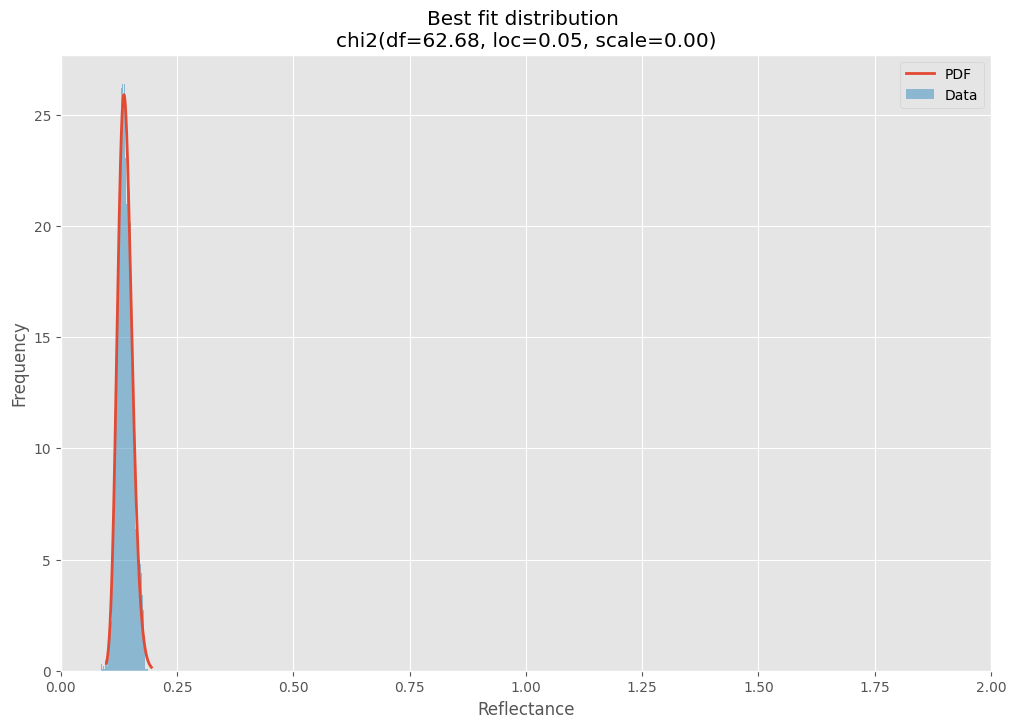

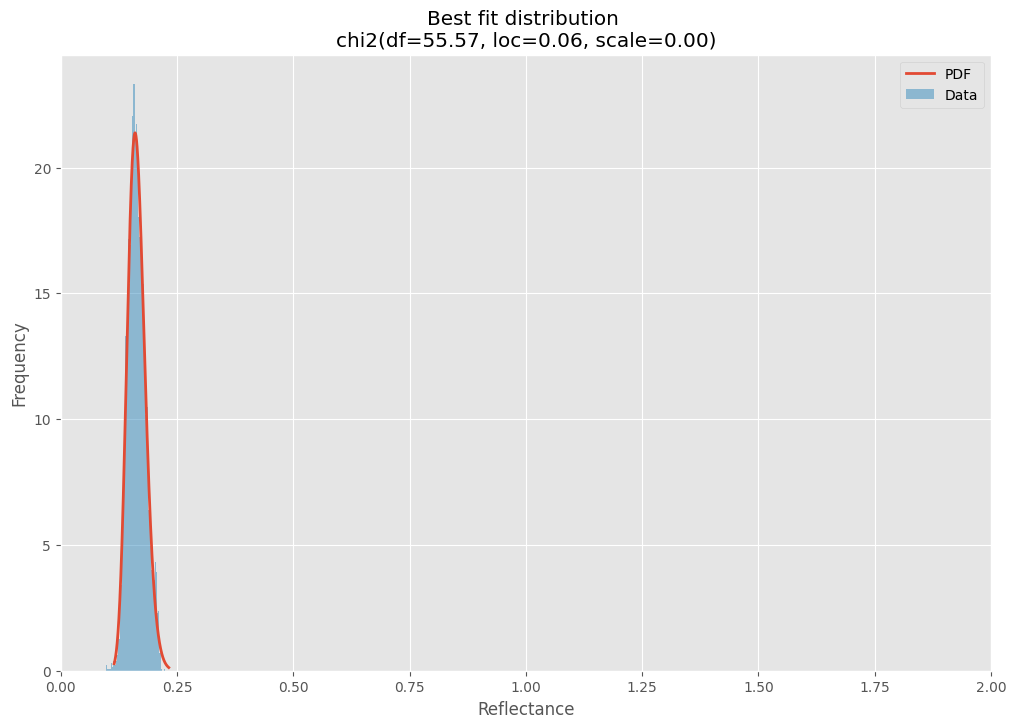

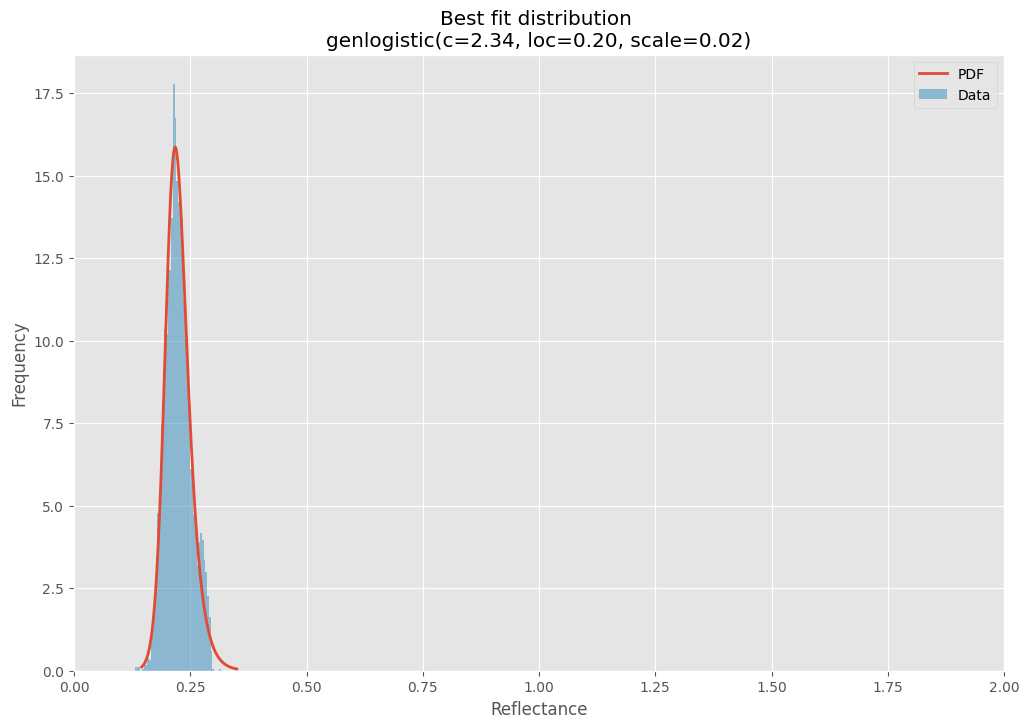

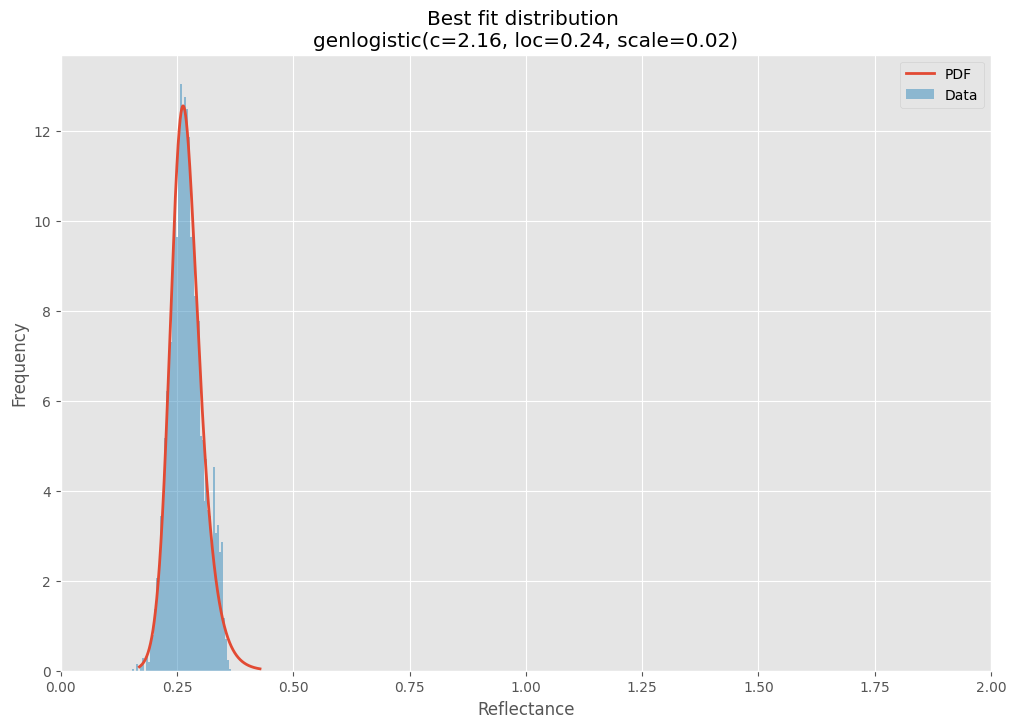

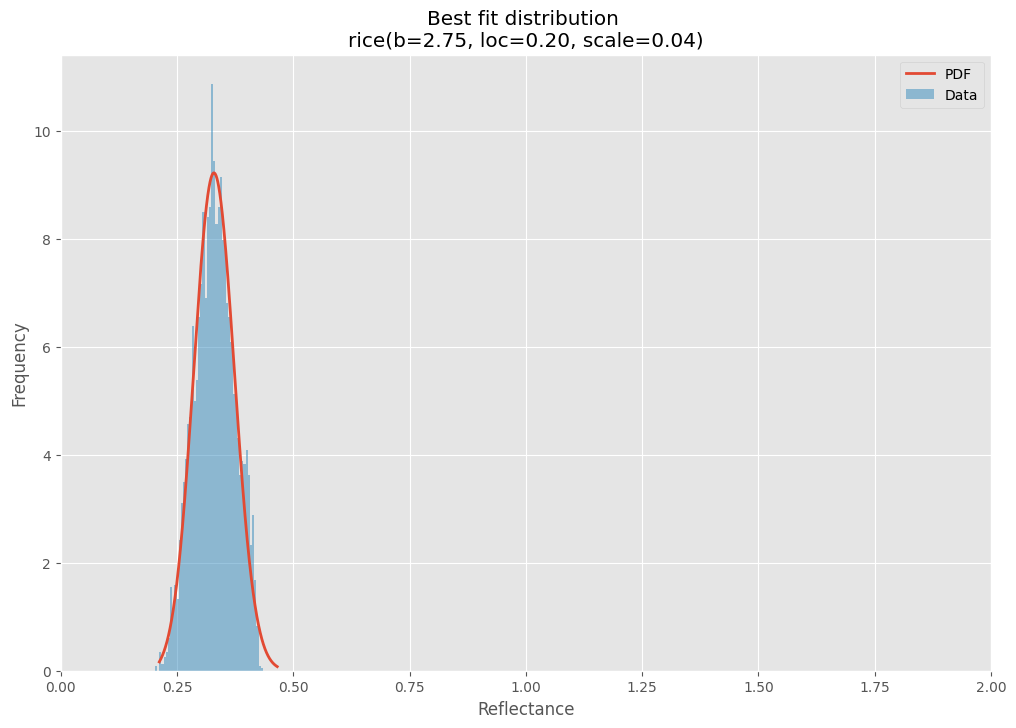

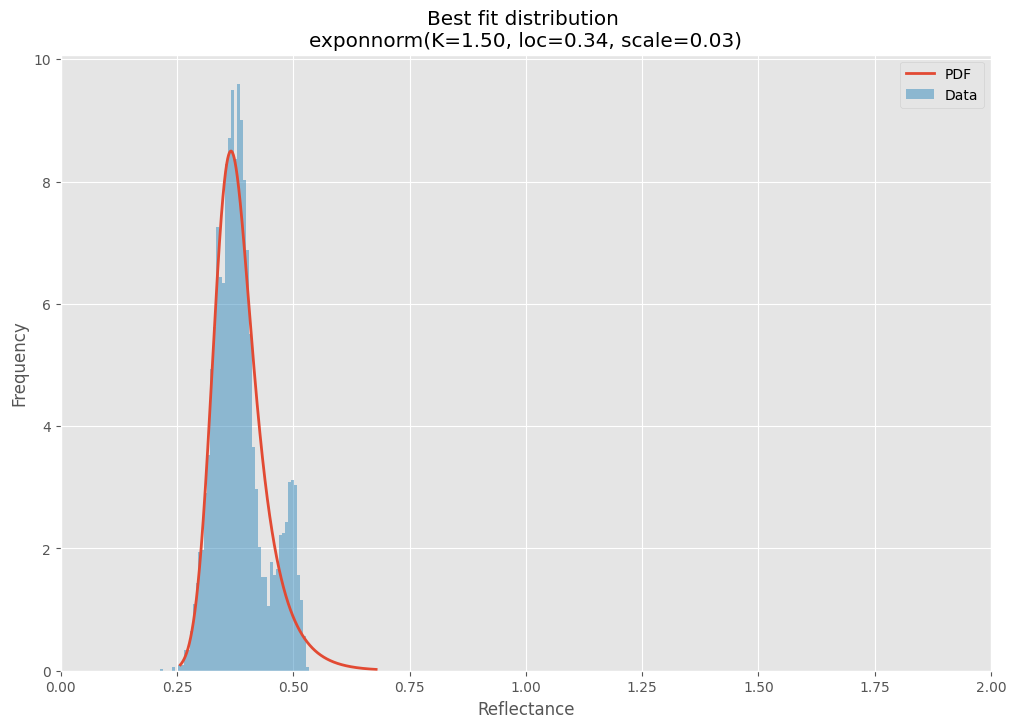

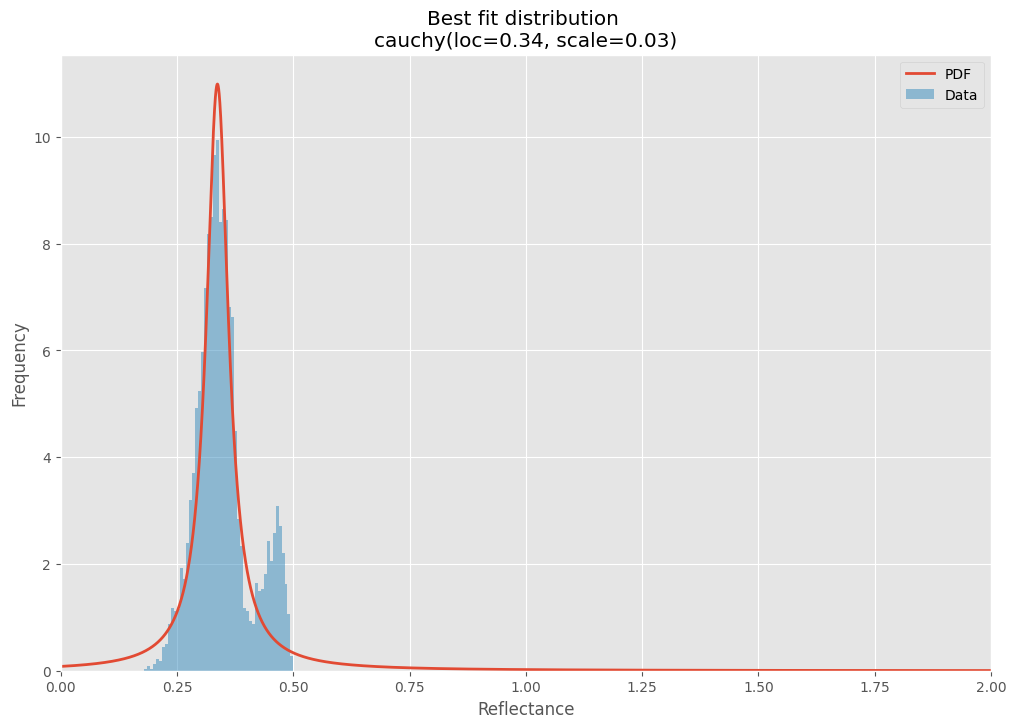

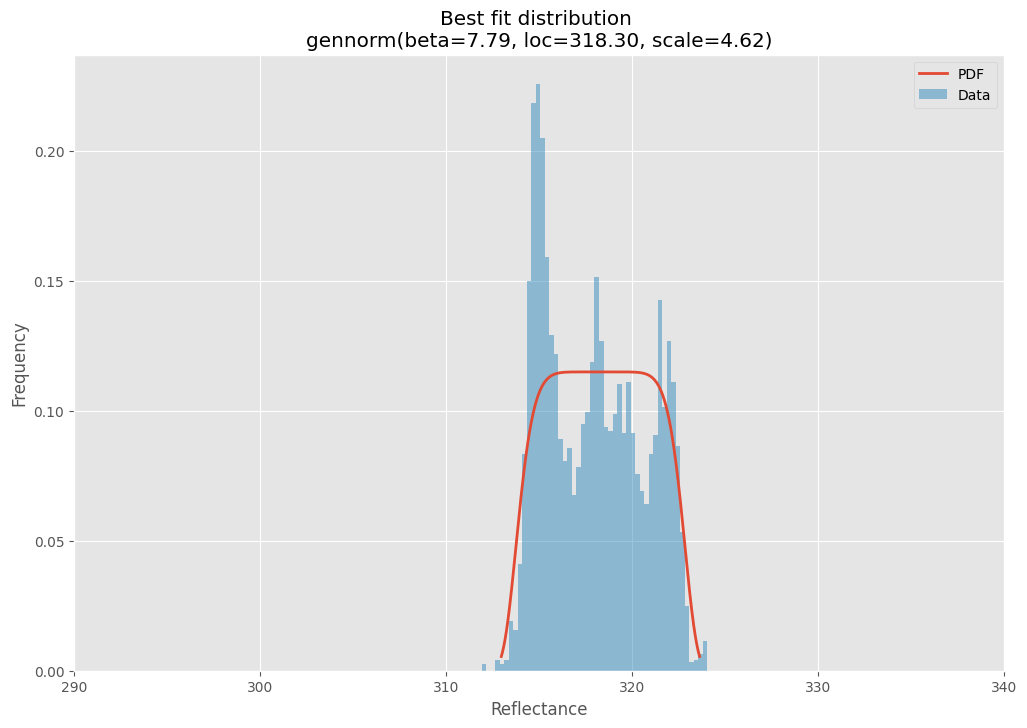

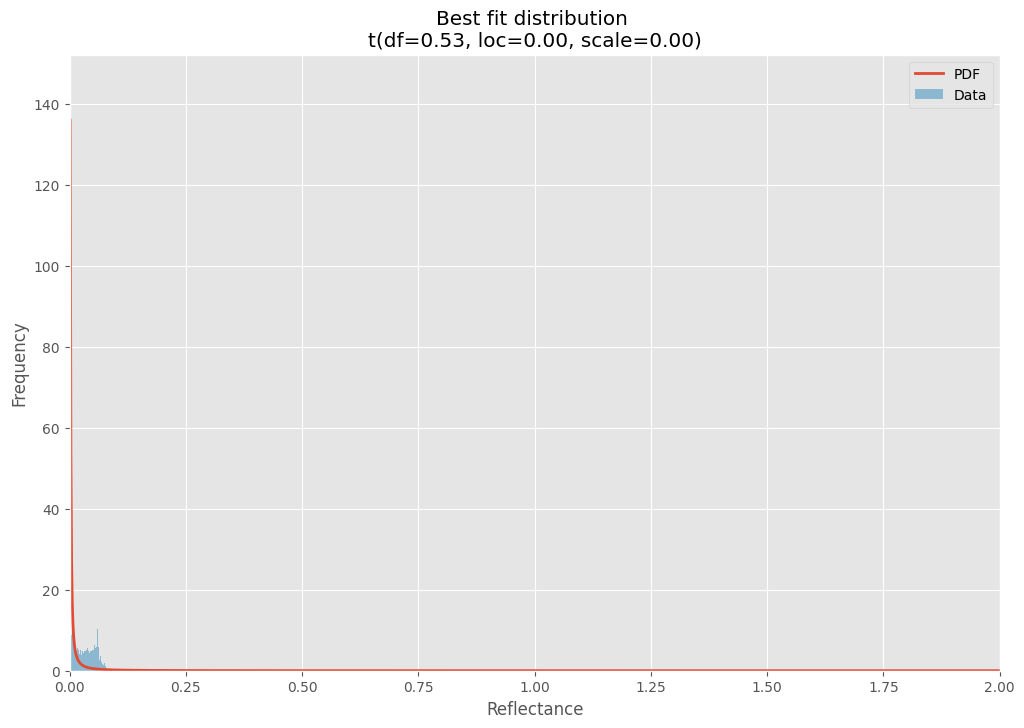

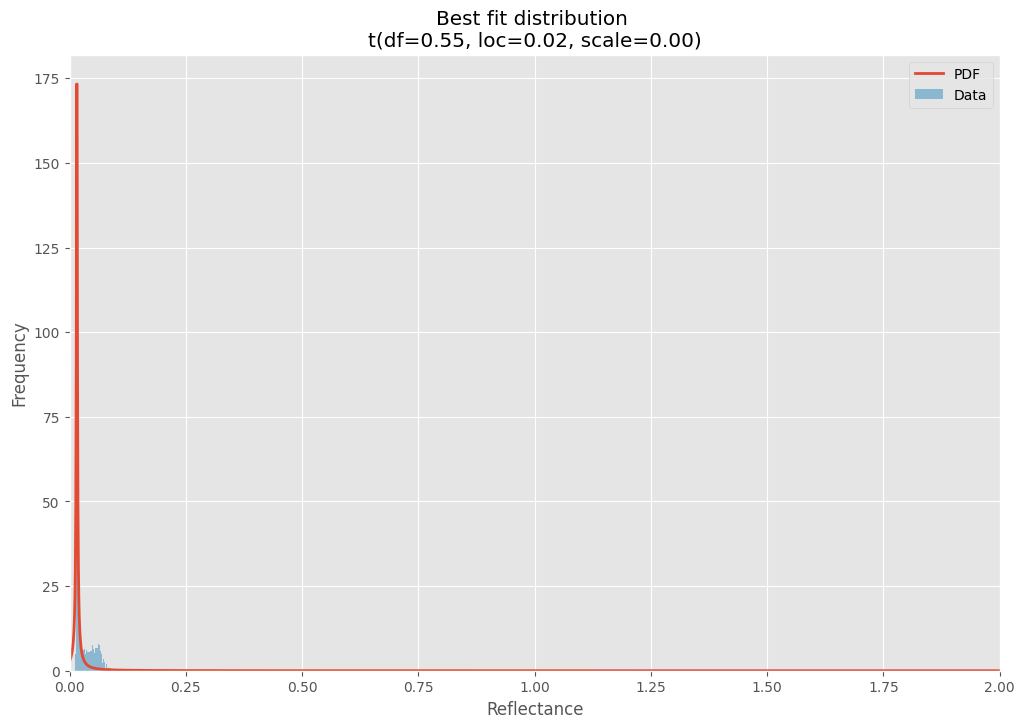

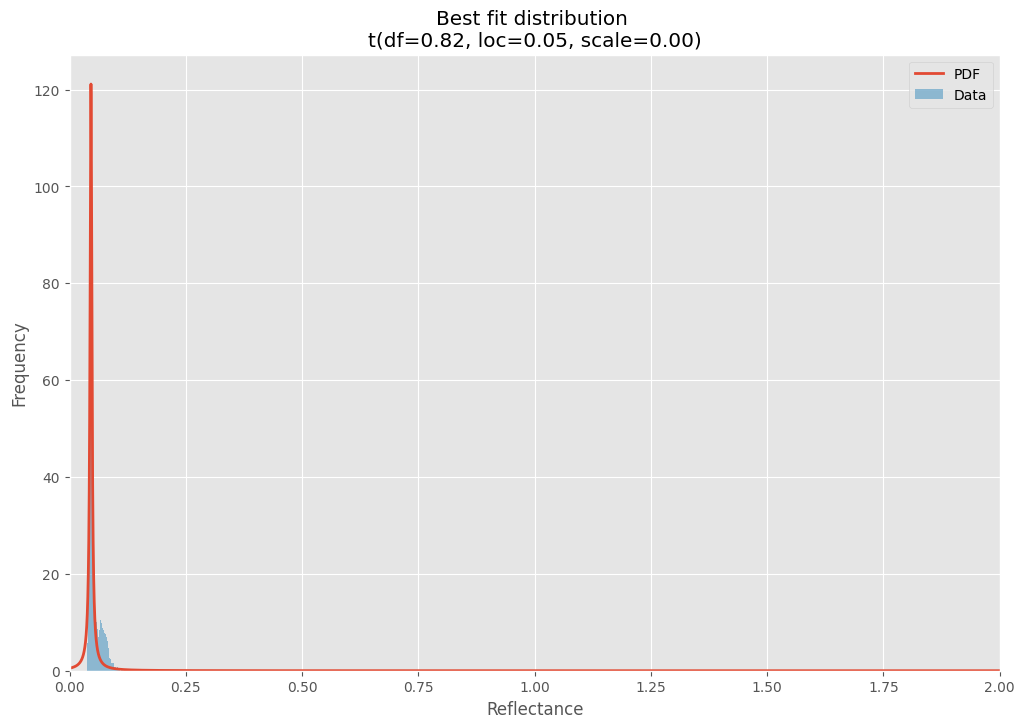

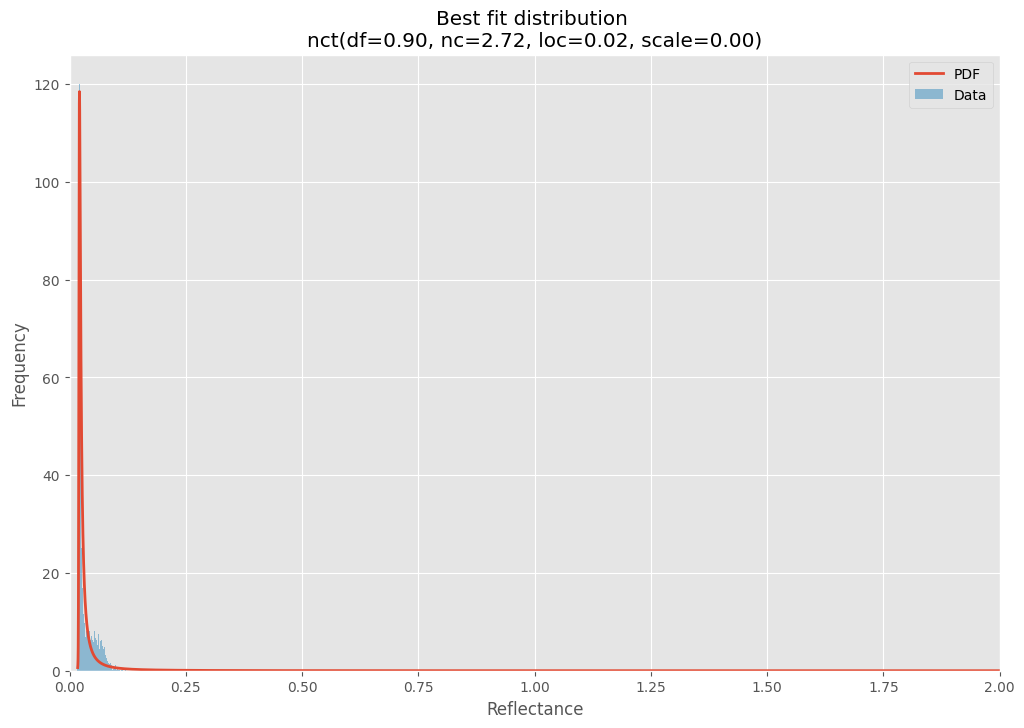

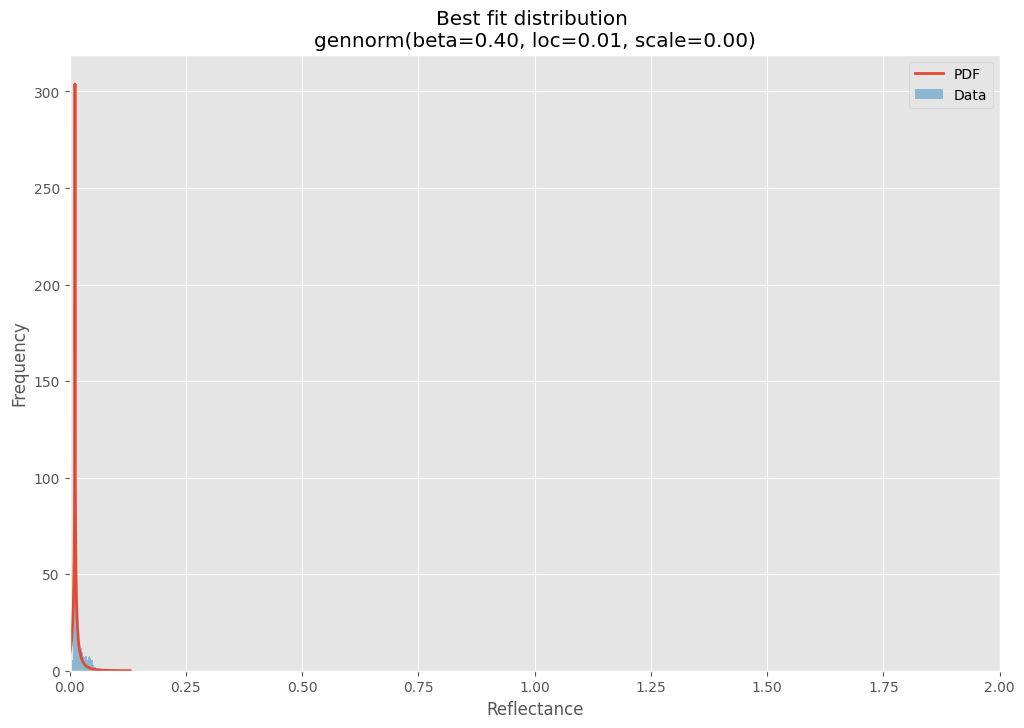

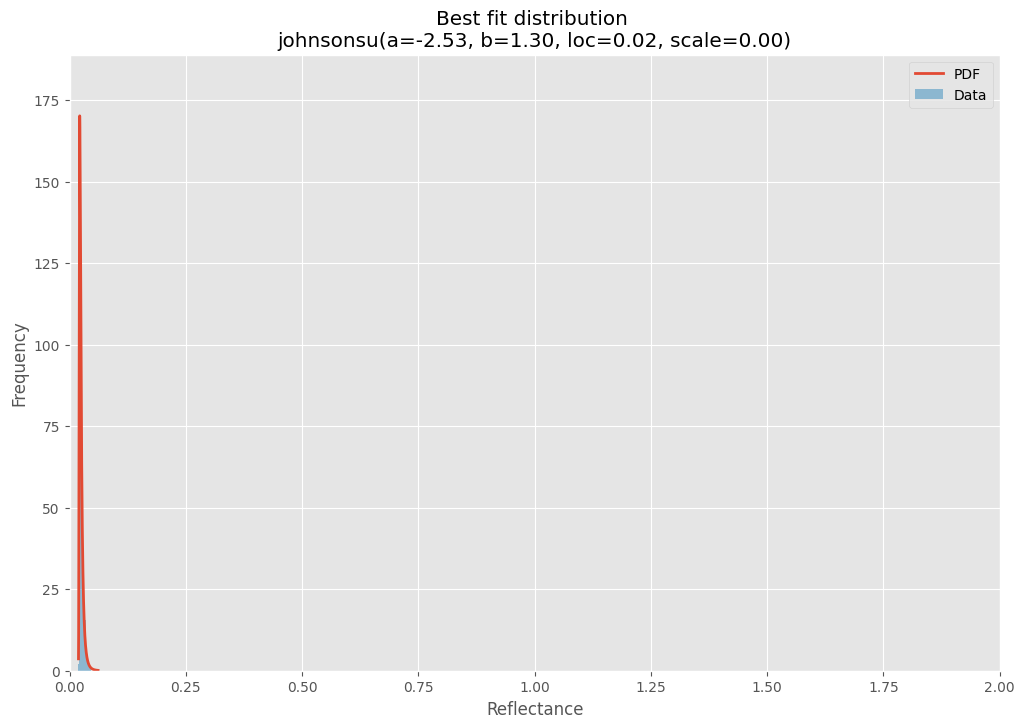

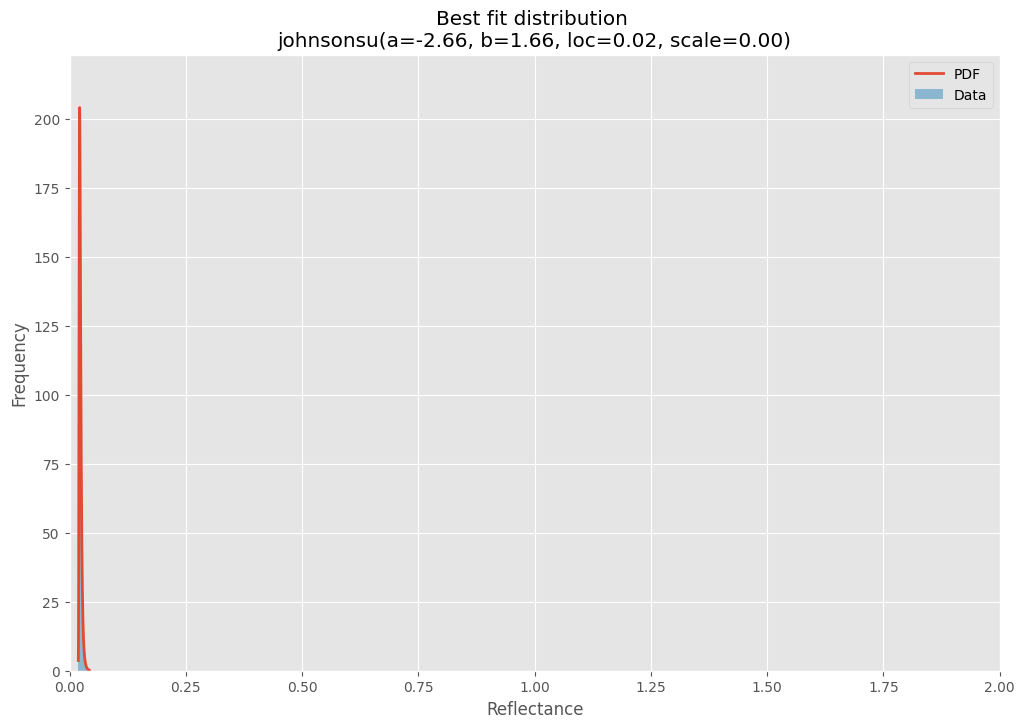

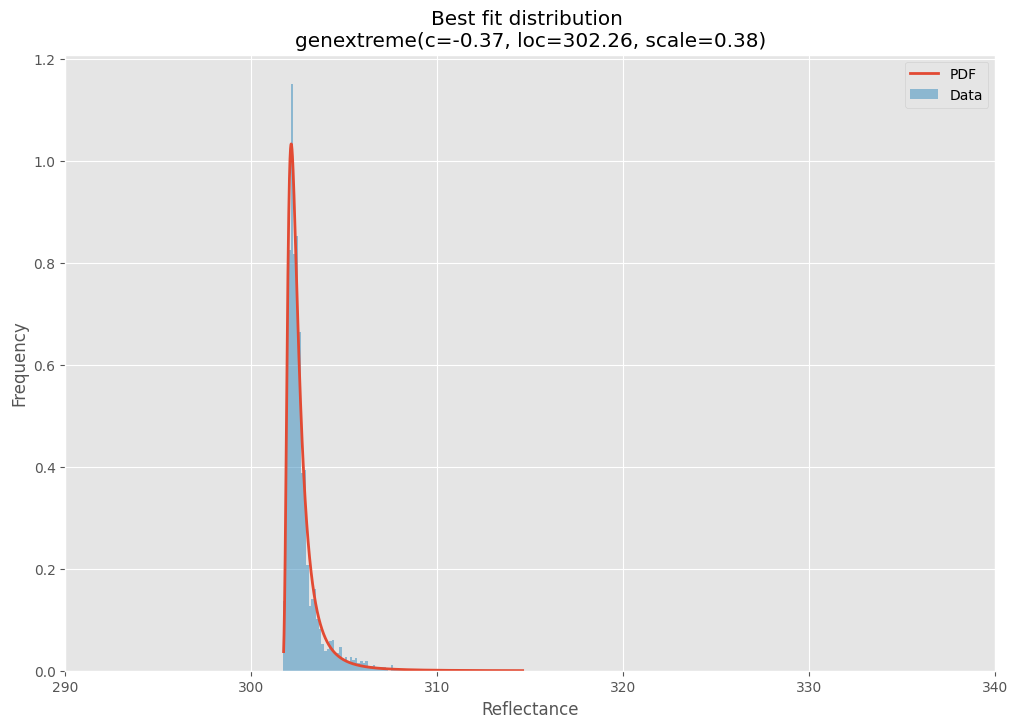

In [125]:
# Display Selected Data with Fitted PDFs

def DsiplayBandsFit(gdf,pdf_bands,best_dist_Bands):
  my_lis=gdf.columns

  for index,item in enumerate(my_lis):

    data=gdf.iloc[:,index]
    pdf=pdf_bands[index]
    best_dist = best_dist_Bands[index][2]

    plt.figure(figsize=(12,8))

    ax = pdf.plot(lw=2, label='PDF', legend=True)
    data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

    param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
    dist_str = '{}({})'.format(best_dist[0].name, param_str)

    ax.set_title(u'Best fit distribution \n' + dist_str)
    ax.set_xlabel(u'Reflectance')
    ax.set_ylabel('Frequency')
    if item == 'ST_B10' or item == 'ST_B6':
      ax.set_xlim([290, 340])
    else:
      ax.set_xlim([0, 2])


DsiplayBandsFit(gdf_Land,pdf_Land,BestFit_Land)

DsiplayBandsFit(gdf_Water,pdf_Water,BestFit_Water)


In [ ]:
# Water Percentages to Simulate

SS=list(range(0, 100+1,10))

# Empty List to Store Simulation Data

NPP_F=np.empty([len(SS),1+len(gdf_Land.columns)])

# Convert Statistical estimated data to numpy
X_Land=np.array(X_Land)
Y_Land=np.array(Y_Land)
Y_Land[Y_Land<0]=0
X_Water=np.array(X_Water)
Y_Water=np.array(Y_Water)
Y_Water[Y_Water<0]=0

size=list(range(0, 10))
kk=-1
# Iterate Over WaterPercentages

for k in SS:
    kk=kk+1
    # Water Percentage
    Per_Water_Sim=k
    # Land Percentage
    Per_Land_Sim=100-Per_Water_Sim
    print('WaterPercent =', Per_Water_Sim)
    NPP_F[kk,0]=Per_Water_Sim

    # Iterate Over Number of Bands for a single water percentage
    for i in range(len(gdf_Land.columns)):

      # Empty List to Store Sample Data
      samples_Land=[]
      samples_Water=[]

      samples1 = np.random.choice(X_Land[i], size=Per_Land_Sim, p=Y_Land[i]/np.sum(Y_Land[i]))
      samples_Land.append(samples1)
      samples2 = np.random.choice(X_Water[i], size=Per_Water_Sim, p=Y_Water[i]/np.sum(Y_Water[i]))
      samples_Water.append(samples2)


      # Multilook SubPixels to create Spectral Signature of 30 by 30 Pixel
      F=np.concatenate((samples_Land, samples_Water), axis=1)

      NPP=np.average(F, axis=1)
      NPP_F[kk,i+1]=NPP

# Export Simulation Data
y=NPP_F[:,0]
x=NPP_F[:,1:]
n,m = x.shape
X0 = np.ones((n,1))
x = np.hstack((x,X0))

# Model Water Percentage using Least squares
a = np.vstack(x)
X_Val=np.dot(np.linalg.pinv(np.dot(a.T, a)), np.dot(a.T, y))

# Calculate Water Percentage
if (LS==8):
  WATER_PER=Water_Perc_Cal_LS8(X_Val,LS_Data_median)
else:
  WATER_PER=Water_Perc_Cal_LS7(X_Val,LS_Data_median)

WATER_PER=WATER_PER.updateMask(NDVI.lte(0.4))



In [ ]:
# Export the water percentage image to Google Drive
# specify scale, Folder Name, Image Titile and region.

TITLE= 'WaterPercentage_'+str(YY)

task = ee.batch.Export.image.toDrive(**{
    'image': WATER_PER,
    'description': TITLE,
    'folder':'ShoreLine_Images',
    'scale': 30,
    'region': aoi.getInfo()['coordinates'],
    'maxPixels': 2e9
})
task.start()
import time
while task.active():
  print('Polling for task (id: {}).'.format(task.id))
  time.sleep(5)

### After downloading the water percentage image from Google Drive, use andy geospatial software , e.g. QGIS, to generate Contour Line of 50 %, which corrosponds to the shoreline

# This Section Makes a Timeseries Analysis for the Study Regions.

In [ ]:
# Define Time Frame

# Define analysis time parameters
StartDateYear = 1985
EndDateYear = 2022
StepYear = 1
StartMonth='06'
EndMonth='08'

# Calculate Start and End Times
Year_Date=list(range(StartDateYear, EndDateYear+1, StepYear))
Start_Monitor_Date = [str(YEAR)+'-'+StartMonth+'-01' for YEAR in Year_Date]
End_Monitor_Date = [str(YEAR)+'-'+EndMonth+'-31' for YEAR in Year_Date]

# Print and Check time tables
print(Year_Date)
print(Start_Monitor_Date)
print(End_Monitor_Date)

In [ ]:
# Start Analysis
from google.colab import files

# Create Empty image with zero value
WATER_PER_Monitor=ee.Image(0).select([0], ['Filler'])

for ii, YY in enumerate(Year_Date):

  if (YY>=2013):
    LS=8
  elif (YY < 2012):
    LS=5
  else:
    LS=7

  # Time Frame
  START_DATE = ee.Date(Start_Monitor_Date[ii])
  END_DATE = ee.Date(End_Monitor_Date[ii])

  # Read LANDSAT Data
  if (LS==8):
    # Read Landsat 8
    LS_Data = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
    cols = ['SR_B1',	'SR_B2',	'SR_B3',	'SR_B4',	'SR_B5','SR_B6',	'SR_B7', 'ST_B10']
  elif (LS==7):
    # Read Landsat 7
    LS_Data = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2")
    cols = ['SR_B1',	'SR_B2',	'SR_B3',	'SR_B4',	'SR_B5',	'SR_B7', 'ST_B6']
  else:
    # Read Landsat 5
    LS_Data = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")
    cols = ['SR_B1',	'SR_B2',	'SR_B3',	'SR_B4',	'SR_B5',	'SR_B7', 'ST_B6']

  # Mask Clouds and Clouds Shadow
  LS_Data = LS_Data.map(maskClouds)
  # Filter Dates, Area of Interset and Apply shift and scale
  LS_Data = LS8_Filter(LS_Data,START_DATE,END_DATE,aoi).map(applyScaleFactors)
  # Calculate Median and Clip
  LS_Data_median=ee.Image(LS_Data.median().clip(aoi))

  # Calculate NDVI and MNDWI
  if (LS==8):
    MNDWI= LS_Data_median.normalizedDifference(['SR_B3', 'SR_B6'])
    NDVI= LS_Data_median.normalizedDifference(['SR_B5', 'SR_B4'])
  else:
    MNDWI= LS_Data_median.normalizedDifference(['SR_B2', 'SR_B5'])
    NDVI= LS_Data_median.normalizedDifference(['SR_B4', 'SR_B3'])

  MaskForLand=LS_Data_median.updateMask(NDVI.lte(0.15).gte(0.05)).updateMask(MNDWI.lte(-0.2))
  MaskForWater=LS_Data_median.updateMask(NDVI.lte(-0.2)).updateMask(MNDWI.gte(0.2))

  # Select Training Points from Image
  # Make the training dataset.
  DataSet_Land1 = MaskForLand.sample(**{
      'region': aoi,
      'scale': 30,
      'seed': 42,
      'numPixels': 5000,
      'dropNulls': True,
      'geometries': True  # Set this to False to ignore geometries
  })

  DataSet_Water1 = MaskForWater.sample(**{
      'region': aoi,
      'scale': 30,
      'seed': 42,
      'numPixels': 5000,
      'geometries': True  # Set this to False to ignore geometries
  })

  if (LS==8):
    # Filter Landsat 8
    DataSet_Land1 = DataSet_Land1.filter(ee.Filter.lte('SR_B1', 1.2)).filter(ee.Filter.lte('SR_B2', 1.2)).filter(ee.Filter.lte('SR_B3', 1.2)) \
                  .filter(ee.Filter.lte('SR_B4', 1.2)).filter(ee.Filter.lte('SR_B5', 1.2)).filter(ee.Filter.lte('SR_B6', 1.2)).filter(ee.Filter.lte('SR_B7', 1.2))
    DataSet_Water1 = DataSet_Water1.filter(ee.Filter.lte('SR_B1', 1.2)).filter(ee.Filter.lte('SR_B2', 1.2)).filter(ee.Filter.lte('SR_B3', 1.2)) \
                  .filter(ee.Filter.lte('SR_B4', 1.2)).filter(ee.Filter.lte('SR_B5', 1.2)).filter(ee.Filter.lte('SR_B6', 1.2)).filter(ee.Filter.lte('SR_B7', 1.2))
  else:
    # Filter Landsat 7 & 5
    DataSet_Land1 = DataSet_Land1.filter(ee.Filter.lte('SR_B1', 1.2)).filter(ee.Filter.lte('SR_B2', 1.2)).filter(ee.Filter.lte('SR_B3', 1.2)) \
                  .filter(ee.Filter.lte('SR_B4', 1.2)).filter(ee.Filter.lte('SR_B5', 1.2)).filter(ee.Filter.lte('SR_B7', 1.2))
    DataSet_Water1 = DataSet_Water1.filter(ee.Filter.lte('SR_B1', 1.2)).filter(ee.Filter.lte('SR_B2', 1.2)).filter(ee.Filter.lte('SR_B3', 1.2)) \
                  .filter(ee.Filter.lte('SR_B4', 1.2)).filter(ee.Filter.lte('SR_B5', 1.2)).filter(ee.Filter.lte('SR_B7', 1.2))


  # Limit data to 5000 points
  DataSet_Land=DataSet_Land1.limit(5000)
  DataSet_Water=DataSet_Water1.limit(5000)

  # Convert to Pandas
  gdf_Land = geemap.ee_to_pandas(DataSet_Land)
  gdf_Water = geemap.ee_to_pandas(DataSet_Water)
  # Make sure the Bands are in Correct Order
  gdf_Land = gdf_Land[cols]
  gdf_Water = gdf_Water[cols]

  # Find best PDF
  BestFit_Land=FindBestFitIterate(gdf_Land)
  BestFit_Water=FindBestFitIterate(gdf_Water)

  # Create Distribution
  size=10000
  [pdf_Land, X_Land, Y_Land]=FindBestFitPDF(gdf_Land,BestFit_Land,size)
  [pdf_Water, X_Water, Y_Water]=FindBestFitPDF(gdf_Water,BestFit_Water,size)

  ##########################
  ##########################

  # Water Percentages to Simulate
  SS=list(range(0, 100+1,10))

  # Empty List to Store Simulation Data
  NPP_F=np.empty([len(SS),1+len(gdf_Land.columns)])

  # Convert Statistical estimated data to numpy
  X_Land=np.array(X_Land)
  Y_Land=np.array(Y_Land)
  Y_Land[Y_Land<0]=0
  X_Water=np.array(X_Water)
  Y_Water=np.array(Y_Water)
  Y_Water[Y_Water<0]=0

  size=list(range(0, 10))
  kk=-1
  # Iterate Over WaterPercentages
  for k in SS:
      kk=kk+1
      # Water Percentage
      Per_Water_Sim=k
      # Land Percentage
      Per_Land_Sim=100-Per_Water_Sim
      print('WaterPercent =', Per_Water_Sim)
      NPP_F[kk,0]=Per_Water_Sim

      # Iterate Over Number of Bands for a single water percentage
      for i in range(len(gdf_Land.columns)):

        # Empty List to Store Sample Data
        samples_Land=[]
        samples_Water=[]

        samples1 = np.random.choice(X_Land[i], size=Per_Land_Sim, p=Y_Land[i]/np.sum(Y_Land[i]))
        samples_Land.append(samples1)
        samples2 = np.random.choice(X_Water[i], size=Per_Water_Sim, p=Y_Water[i]/np.sum(Y_Water[i]))
        samples_Water.append(samples2)


        # Multilook SubPixels to create Spectral Signature of 30 by 30 Pixel
        F=np.concatenate((samples_Land, samples_Water), axis=1)

        NPP=np.average(F, axis=1)
        NPP_F[kk,i+1]=NPP

  # Export Simulation Data
  y=NPP_F[:,0]
  x=NPP_F[:,1:]
  n,m = x.shape
  X0 = np.ones((n,1))
  x = np.hstack((x,X0))

  # Model Water Percentage using Least squares
  a = np.vstack(x)
  X_Val=np.dot(np.linalg.pinv(np.dot(a.T, a)), np.dot(a.T, y))

  # Calculate Water Percentage
  if (LS==8):
    WATER_PER=Water_Perc_Cal_LS8(X_Val,LS_Data_median)
  else:
    WATER_PER=Water_Perc_Cal_LS7(X_Val,LS_Data_median)

  WATER_PER=WATER_PER.updateMask(NDVI.lte(0.4))


  # Export the water percentage image to Google Drive
  # specify scale, Folder Name, Image Titile and region.

  TITLE= 'WaterPercentage_'+str(YY)

  task = ee.batch.Export.image.toDrive(**{
      'image': WATER_PER,
      'description': TITLE,
      'folder':'ShoreLine_Images',
      'scale': 30,
      'region': aoi.getInfo()['coordinates'],
      'maxPixels': 2e9
  })
  task.start()
  import time
  while task.active():
    print('Polling for task (id: {}).'.format(task.id))
    time.sleep(5)

### After downloading the water percentage image from Google Drive, use andy geospatial software , e.g. QGIS, to generate Contour Line of 50 %, which corrosponds to the shoreline